# Analysis pipeline for male _Ae. aegypti_ reproductive tract RNAseq
### Degner _et al_.

### Load the required packages and raw data files:

Load the reuired packages for the analyses/plotting:

In [1]:
req_packages = c("ballgown", "Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "genefilter", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", 
                 "VennDiagram")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())

Loading required package: ballgown

Attaching package: ‘ballgown’

The following object is masked from ‘package:base’:

    structure

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, un

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE

[[28]]
[1] TRUE

[[29]]
[1] TRUE

In addition, several convenient plotting and annotation functions are available in the `Functions2.R` file, so load as source:

In [2]:
source("Functions2.R")

Now load the raw count matrix

In [3]:
countsMatrix = read.csv(file = "L5.data/expression_data/gene_counts.csv", header = T, sep = ",", row.names = 1)
pheno_data = read.table("sampleInfo.txt", header = T)

We'll also need the gffcompare output to include the VectorBase gene IDs:

In [4]:
gffcmp.loci = read.table("L5.data/gffcompare/gffcmp.loci", header = F)
gffcmp.tracking = read.table("L5.data/gffcompare/gffcmp.tracking", header = F)
gffcmp.tmap = read.table("L3.data/gffcompare/gffcmp.stringtie_merged.gtf.tmap", header = T)
gffcmp.refmap = read.table("L5.data/gffcompare/gffcmp.stringtie_merged.gtf.refmap", header = T)

Also additional annotation information:

In [5]:
gene.coords = read.table("L5.data/annotation/coordinates.txt", header = T)
gene.features = read.table("L5.data/annotation/features.txt", header = T)
gene.annotations = read.table("L5.data/annotation/product_annotation.txt", header =T, sep = "\t")

Finally, we'll input the sample information and add sample features based on sample names:

In [6]:
sampleData = read.table("sample_replicate_map.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]
colnames(sampleData) = c("Sample", "Replicate")
## Add a tissue column
sampleData$Tissue = ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "MAG", ifelse(grepl("TS", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "fRT", ifelse(grepl("CR", sampleData$Sample, ignore.case = F), "carcass", "Sperm")))))
## Add a source column
sampleData$Source = ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", sampleData$Sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", sampleData$Sample, ignore.case = F), "Akbari", "Sutton")))))
## Check the table
head(sampleData)

Sample,Replicate,Tissue,Source
Fe_RT_0hpm,Fe_RT_0hpm_1,fRT,Alfonso-Parra
Fe_RT_0hpm,Fe_RT_0hpm_2,fRT,Alfonso-Parra
Fe_RT_24hpm,Fe_RT_24hpm_1,fRT,Alfonso-Parra
Fe_RT_24hpm,Fe_RT_24hpm_2,fRT,Alfonso-Parra
Fe_RT_6hpm,Fe_RT_6hpm_1,fRT,Alfonso-Parra
Fe_RT_6hpm,Fe_RT_6hpm_2,fRT,Alfonso-Parra


### Basic QC and gene filtering:

We'll take a quick look at the library size distribution of each sample:

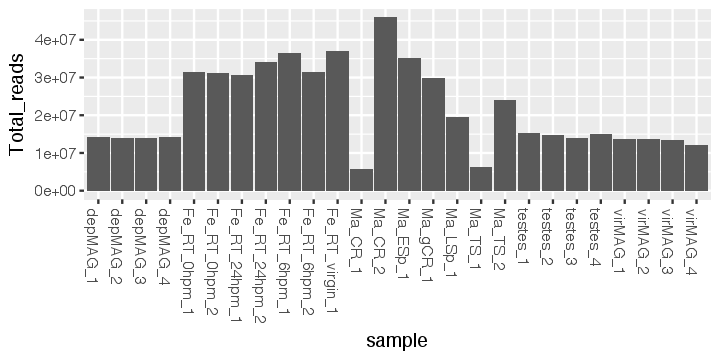

In [7]:
libSizes <- as.data.frame(colSums(countsMatrix))
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Total_reads")
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(libSizes, aes(sample, Total_reads)) + 
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0))

For subsequent analysis we have to filter out genes with very low expression:

In [8]:
all.CPM <- cpm(countsMatrix)
thresh <- all.CPM > 5
keep <- rowSums(thresh) >= 4
counts.keep <- countsMatrix[keep,]
dim(counts.keep)

[1] 12329    26

Using the threshold above applies well for Ethan's data (note the 3' read difference with other samples). If we filter low expression data at 10 CPM, that's equal to an average of 150 reads/gene for Ethan's data.

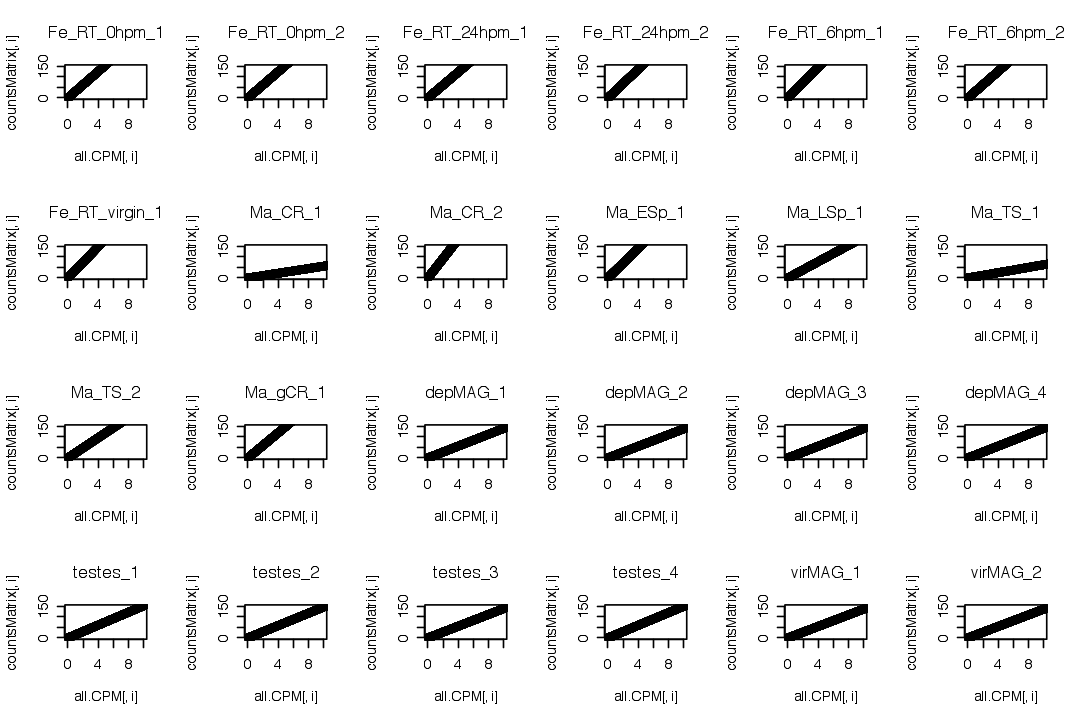

In [9]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(4,6))
for(i in seq(from=1, to=24, by=1)){
  plot(all.CPM[,i],countsMatrix[,i], xlim=c(0,10), ylim=c(0,150))
  title(colnames(all.CPM)[i])
}

We'll need to reshape the CPM matrix to calculate means and for convenient heatmap and gene plotting later:

In [10]:
tmp.cpmMatrix<-all.CPM
colnames(tmp.cpmMatrix) <- sampleData$Sample
tmp.cpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.cpmMatrix)))
colnames(tmp.cpmMatrix.m) <- c("gene_id", "sample", "CPM")

tmp.cpmMatrix.m$Tissue = ifelse(grepl("MAG", tmp.cpmMatrix.m$sample, ignore.case = F), "MAG", ifelse(grepl("TS", tmp.cpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("testes", tmp.cpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("RT", tmp.cpmMatrix.m$sample, ignore.case = F), "fRT", ifelse(grepl("CR", tmp.cpmMatrix.m$sample, ignore.case = F), "carcass", "Sperm")))))

tmp.cpmMatrix.m$Source = ifelse(grepl("RT", tmp.cpmMatrix.m$sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", tmp.cpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("testes", tmp.cpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", tmp.cpmMatrix.m$sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", tmp.cpmMatrix.m$sample, ignore.case = F), "Akbari", "Sutton")))))

Now we'll calculate the CPM mean and standard deviation/error for each gene across samples (warning: this will take a few minutes):

In [11]:
tmp.cpmMatrix.m.c = summarySE(tmp.cpmMatrix.m, measurevar = "CPM", groupvars = c("gene_id", "sample", "Tissue", "Source"))

Warning message in qt(conf.interval/2 + 0.5, datac$N - 1):
"NaNs produced"

In [12]:
CPMse <- tmp.cpmMatrix.m.c

We can use the CPM means to make a mean CPM matrix for heatmaps:

In [13]:
tmpMat <- cast(CPMse, gene_id~sample, value = "CPM")
meanCPMmatrix <- tmpMat[,-1]
rownames(meanCPMmatrix) <- tmpMat[,1]

Now we can subset and combine `gene_id`'s with annotation information:

In [14]:
head(gene.annotations)

gene_name,description
LOC110673976,uncharacterized LOC110673976
LOC110673977,PRKCA-binding protein-like
LOC110673978,cytochrome c oxidase subunit 7A1%2C mitochondrial-like
LOC110673979,mitochondrial intermembrane space import and assembly protein 40
LOC110673980,cytosolic 10-formyltetrahydrofolate dehydrogenase-like
LOC110673981,sodium-coupled monocarboxylate transporter 2


In [15]:
ref_to_gene = unique(subset(gene.features, select = c("gene_id", "gene_name")))
ref_to_gene_to_annots = (merge(gene.annotations, ref_to_gene, all = T))
annots = subset(ref_to_gene_to_annots, gene_id %in% rownames(countsMatrix))
annots = unique(subset(annots, select = c("gene_id", "description")))
head(annots)

gene_id,description
MSTRG.19652,uncharacterized LOC110673976
MSTRG.17087,PRKCA-binding protein-like
MSTRG.21946,cytochrome c oxidase subunit 7A1%2C mitochondrial-like
MSTRG.5248,mitochondrial intermembrane space import and assembly protein 40
MSTRG.17334,cytosolic 10-formyltetrahydrofolate dehydrogenase-like
MSTRG.22847,sodium-coupled monocarboxylate transporter 2


We'll set the factor level for samples in the `CPMse` dataframe so that samples are ordered the way we want:

In [16]:
CPMse$sample = factor(CPMse$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

## DIfferential expression: tissue-biased male reproductive genes:

We need to identify several categories of genes: (1) testes-biased geens, (2) MAG-biased genes, and (3) genes that are differentially expressed between virgin MAGs and depleted MAGS.

First we'll determine the grouping of samples and set-up the model matrix:

In [17]:
groups = factor(sampleData$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleData$Replicate

Now we'll create the edgeR DGE object with these groupings and fir the genelized linear model:

In [18]:
dgeList <- DGEList(counts = counts.keep, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)

Add annotation information:

In [19]:
# Extract annotation for genes in the fit object
ann = subset(annots, gene_id %in% rownames(dgeList_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_fit), ann$gene_id),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_fit$genes = ann


 TRUE 
12329 

We can look at the variability by examining the tagwise dispersion:

In [20]:
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04757 0.08106 0.13430 0.22550 0.24640 6.28800 

We can take a closer look at the DE materics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot:

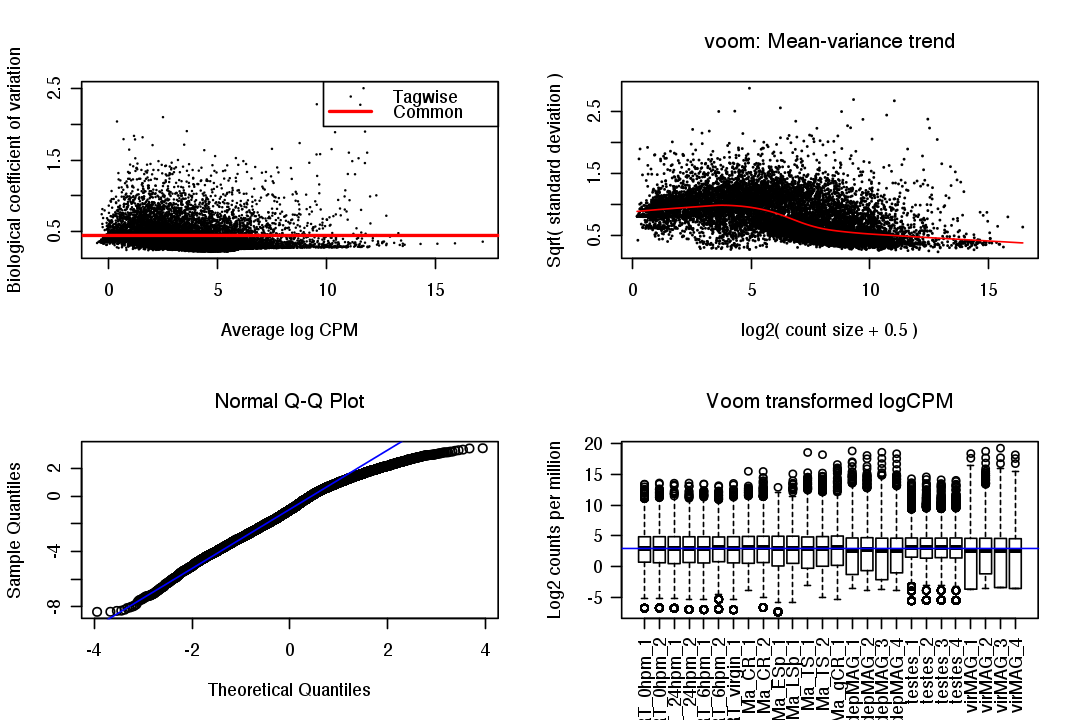

In [21]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
voomC = voom(dgeList, design, plot=TRUE)
# QQ-plot
g <- gof(dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

An interactive MDS plot gives an idea of how replicates/samples are grouping:

In [22]:
glMDSPlot(dgeList, groups = dgeList$samples$group, labels = sampleData$Tissue)

... or a statis plot works too:

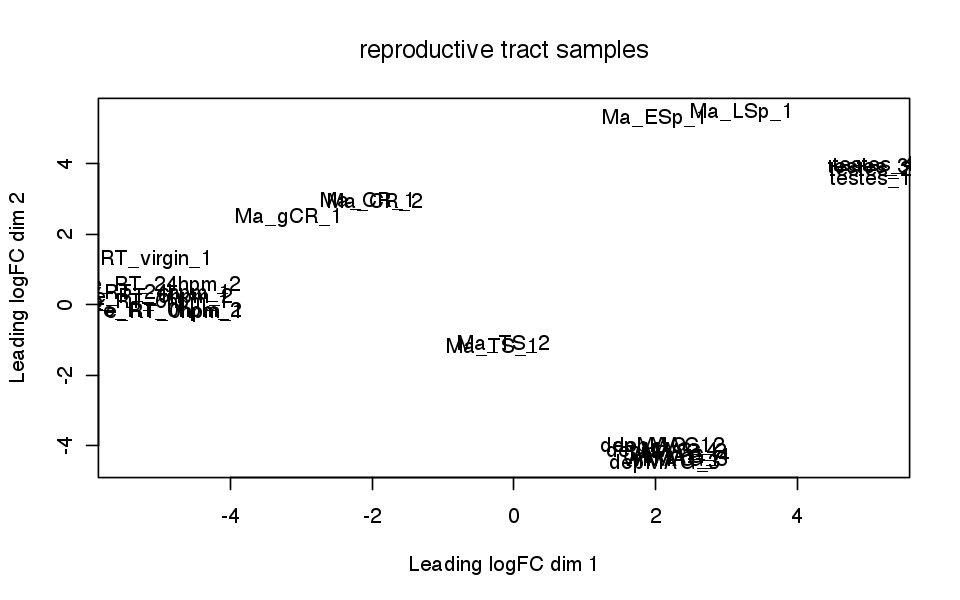

In [23]:
## colour samples by tissue-type
col.Tissue <- sampleData$Tissue
chr.Source <- sampleData$Source

options(repr.plot.width = 8, repr.plot.height = 5)
plotMDS(dgeList)
# legend("topright",legend=levels(sampleData$Tissue), fill = c("#8d75ca","#78a450","#c16786","#afc64f","#dd70cd"), cex = 1)
# legend("bottomright",legend=levels(sampleData$Source), pch = c(21:24), cex = 1)
# Add a title
title("reproductive tract samples")

A heatmap of sample correlations is also useful

for plotting:: min.raw: 0.081452956581715 max.raw: 1


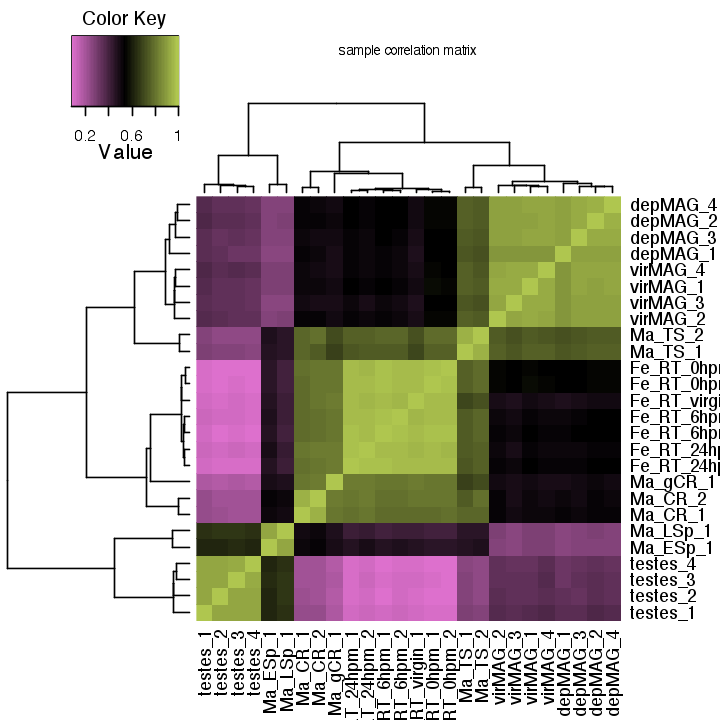

In [24]:
data = log2(counts.keep+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 6, repr.plot.height = 6)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Now we're ready to define the contrasts. For the three DE tests to be performed, the following contrasts can be defined:

In [25]:
testes.v.rest <- makeContrasts(testes.v.gCR=testes-Ma_gCR,
                                 testes.v.MAG=testes-virMAG,
                                 testes.vs.fRT=testes-Fe_RT_virgin,
                                 levels=design)
MAG.v.rest <- makeContrasts(MAG.v.gCR=virMAG-Ma_gCR,
                                 MAG.v.testes=virMAG-testes,
                                 MAG.vs.fRT=virMAG-Fe_RT_virgin,
                                 levels=design)
vMAG.v.dMAG <- makeContrasts(vMAG.vs.dMAG=virMAG-depMAG,
                             levels=design)

##### Testes-biased genes:

To identify those genes, we'll perform a likelihood ratio test on the GLM fir object that compares the testes sample to the gonadectomized carcass sample, the MAG sample, and the virgin female RT sample. We'll then define testes-biased genes as those showing ≥4-fold increase in expression relative to the other tissues, with an FDR < 0.001.

In [31]:
lrt.testes <- glmLRT(dgeList_fit, contrast = testes.v.rest)

lrt.testes.tTags <- topTags(lrt.testes, n = NULL)
lrt.testes.tTags.table <- lrt.testes.tTags$table
testes.list<-subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 2 & logFC.testes.v.MAG > 2 & logFC.testes.vs.fRT > 2 & FDR<0.001)$GeneID
length(testes.list)
head(subset(lrt.testes.tTags.table, GeneID %in% testes.list))

[1] 2284

,GeneID,Description,logFC.testes.v.gCR,logFC.testes.v.MAG,logFC.testes.vs.fRT,logCPM,LR,PValue,FDR
274,MSTRG.6662,outer dense fiber protein 3,19.21423,7.909070,19.21423,9.061283,671.1777,3.729299e-145,1.021745e-142
1854,MSTRG.31819,plasminogen,14.46998,8.355411,20.80436,10.571715,659.4646,1.292056e-142,3.462992e-140
5070,MSTRG.2878,NA,14.41910,8.232842,18.99015,8.542429,644.1494,2.702913e-139,6.800860e-137
9155,MSTRG.16892,uncharacterized LOC110676642,11.55076,8.385201,17.88514,7.926183,633.7821,4.781383e-137,1.052673e-134
11763,MSTRG.5458,NA,15.84000,8.503510,12.79103,5.440328,626.9090,1.477966e-135,3.196815e-133
8299,MSTRG.1040,uncharacterized LOC110674840,13.46364,8.493047,15.55031,8.320110,613.4114,1.247184e-132,2.480086e-130


In [30]:
lrt.MAG <- glmLRT(dgeList_fit, contrast = MAG.v.rest)

lrt.MAG.tTags <- topTags(lrt.MAG, n = NULL)
lrt.MAG.tTags.table <- lrt.MAG.tTags$table
MAG.list<-subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 2 & logFC.MAG.v.testes > 2 & logFC.MAG.vs.fRT > 2 & FDR<0.001)$GeneID
length(MAG.list)
head(subset(lrt.MAG.tTags.table, GeneID %in% MAG.list))

[1] 695

,GeneID,Description,logFC.MAG.v.gCR,logFC.MAG.v.testes,logFC.MAG.vs.fRT,logCPM,LR,PValue,FDR
12271,MSTRG.24624,NA,21.27117,11.53829,16.54506,11.69867,984.1801,4.863196e-213,5.995835e-209
7244,MSTRG.10403,uncharacterized LOC110675574,16.69430,10.61305,16.35342,11.97237,951.1952,6.952143e-206,4.285648e-202
7011,MSTRG.33559,NA,15.85457,11.53661,19.38447,13.36407,929.4164,3.683959e-201,1.513984e-197
5121,MSTRG.32453,NA,15.65184,10.84884,19.55327,12.41563,916.4622,2.378090e-198,7.329868e-195
12272,MSTRG.24625,NA,21.02620,11.64842,15.32760,11.31985,883.6754,3.075331e-191,7.583151e-188
6220,MSTRG.20262,trypsin 3A1-like,21.87539,10.64189,17.14928,12.74422,882.8131,4.730740e-191,9.720882e-188


In [32]:
lrt.dvMAG <- glmLRT(dgeList_fit, contrast = vMAG.v.dMAG)

lrt.dvMAG.tTags <- topTags(lrt.dvMAG, n = NULL)
lrt.dvMAG.tTags.table <- lrt.dvMAG.tTags$table
dvMAG.list<-subset(lrt.dvMAG.tTags.table, logFC > 1 & FDR<0.01)$GeneID
length(dvMAG.list)
# MAG.list
head(subset(lrt.dvMAG.tTags.table, GeneID %in% dvMAG.list))

[1] 276

,GeneID,Description,logFC,logCPM,LR,PValue,FDR
11748,MSTRG.4470,NA,10.986077,1.212647,100.74159,1.048015e-23,1.076749e-20
4758,MSTRG.18144,NA,3.379204,3.215927,97.68479,4.905774e-23,4.652561e-20
5096,MSTRG.1063,NA,3.922924,4.744468,91.60174,1.059997e-21,8.712468e-19
8618,MSTRG.32770,NA,3.492066,3.402315,87.28402,9.400429e-21,7.243618e-18
6635,MSTRG.3633,NA,2.563786,6.570261,73.80199,8.635956e-18,5.323635e-15
1308,MSTRG.13300,NA,2.457522,8.069908,65.75626,5.102822e-16,2.169403e-13


In [33]:
MAG_factors = as.data.frame(MAG.list)
MAG_factors$V1 = "MAG-biased"
rownames(MAG_factors) = MAG.list
MAG_factors = subset(MAG_factors, select = "V1")

testes_factors = as.data.frame(testes.list)
testes_factors$V1 = "testes-biased"
rownames(testes_factors) = testes.list
testes_factors = subset(testes_factors, select = "V1")

dvMAG_factors = as.data.frame(dvMAG.list)
dvMAG_factors$V1 = "MAG.DE"
rownames(dvMAG_factors) = dvMAG.list
dvMAG_factors = subset(dvMAG_factors, select = "V1")

factor.labeling = rbind(MAG_factors, testes_factors, dvMAG_factors)
colnames(factor.labeling) = c('tissue_bias')
factor_list = unique(factor.labeling[,1])
tail(factor.labeling)

,tissue_bias
MSTRG.4861,MAG.DE
MSTRG.10541,MAG.DE
MSTRG.30727,MAG.DE
MSTRG.65261,MAG.DE
MSTRG.16667,MAG.DE
MSTRG.5871,MAG.DE


In [34]:
tissueBiased.meanCPM = subset(meanCPMmatrix, rownames(meanCPMmatrix) %in% rownames(factor.labeling))

In [35]:
data = tissueBiased.meanCPM
gene_factors = unique(factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#e1526d", "#b85516", "orange")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

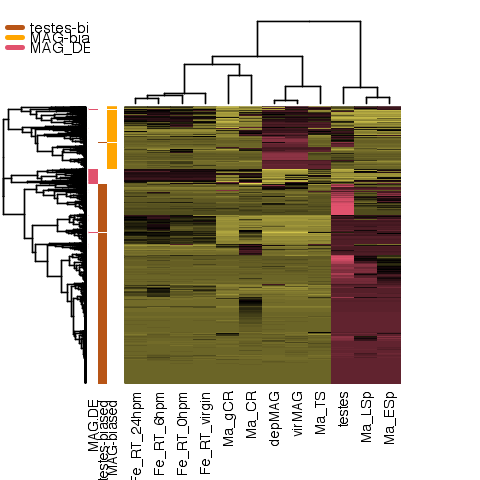

In [36]:
options(repr.plot.width = 4, repr.plot.height = 4)
heatmap3(heatmap_data, 
         col=myheatcol, 
         cexCol = 1, 
         labRow = "", 
         legendfun=function() showLegend(legend=c("testes-biased", "MAG-biased", "MAG_DE"), col=c("#b85516", "orange", "#e1526d")), 
        cex.main=0.75, 
             RowSideColors = geneFactorAnnotations)

Warning message:
"Removed 4 rows containing missing values (geom_errorbar)."

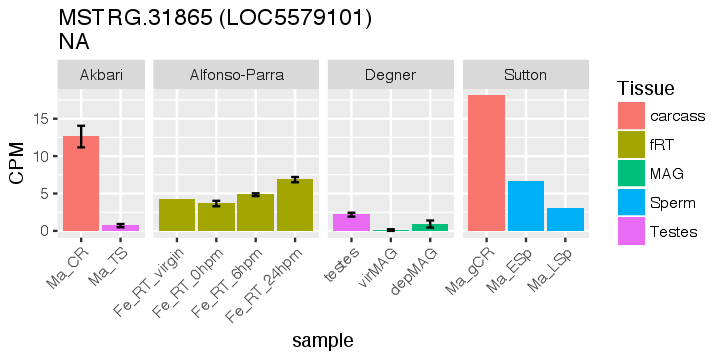

In [76]:
options(repr.plot.width = 6, repr.plot.height = 3)
plotGene(CPMse, "MSTRG.31865")

## DE analysis with just Ethan's data:

In [40]:
e.groups = factor(subset(sampleData, Source == "Degner")$Sample)
e.design = model.matrix( ~ 0 + e.groups)
colnames(e.design) <- levels(e.groups)
rownames(e.design) <- subset(sampleData, Source == "Degner")$Replicate
e.design

,depMAG,testes,virMAG
depMAG_1,1,0,0
depMAG_2,1,0,0
depMAG_3,1,0,0
depMAG_4,1,0,0
testes_1,0,1,0
testes_2,0,1,0
testes_3,0,1,0
testes_4,0,1,0
virMAG_1,0,0,1
virMAG_2,0,0,1


Now we'll create the edgeR DGE object with these groupings and fit the genelized linear model. First we'll subset the count matrix to include Ethan's data only:

In [41]:
e.counts.keep = subset(counts.keep, select=c("depMAG_1", "depMAG_2", "depMAG_3", "depMAG_4", "testes_1", "testes_2", "testes_3", "testes_4", "virMAG_1", "virMAG_2", "virMAG_3", "virMAG_4"))
colnames(e.counts.keep)

# Now filter this subsetted count matrix:

e.CPM <- cpm(e.counts.keep)
e.thresh <- e.CPM > 5
e.keep <- rowSums(e.thresh) >= 4
e.counts.keep <- e.counts.keep[e.keep,]
dim(e.counts.keep)

[1] "depMAG_1" "depMAG_2" "depMAG_3" "depMAG_4" "testes_1" "testes_2"
 [7] "testes_3" "testes_4" "virMAG_1" "virMAG_2" "virMAG_3" "virMAG_4"

[1] 9483   12

In [42]:
e.dgeList <- DGEList(counts = e.counts.keep, group = e.groups)
e.dgeList <- calcNormFactors(e.dgeList)
e.dgeList <- estimateCommonDisp(e.dgeList)
e.dgeList <- estimateTagwiseDisp(e.dgeList)
e.dgeList_fit <- glmFit(e.dgeList, e.design)

Add annotation information:

In [43]:
# Extract annotation for genes in the fit object
ann.e = subset(annots, gene_id %in% rownames(e.dgeList_fit))
# convert factors to characters
ann.e = data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.e = ann.e[match(rownames(e.dgeList_fit), ann.e$gene_id),]
# convert factors to characters, again
ann.e <- data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.e) = c ("GeneID", "Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.e$GeneID==rownames(e.dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
e.dgeList_fit$genes = ann.e


TRUE 
9483 

We can look at the variability by examining the tagwise dispersion:

In [44]:
summary(e.dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05679 0.09447 0.11810 0.19830 0.18280 3.65000 

We can take a closer look at the DE materics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot:

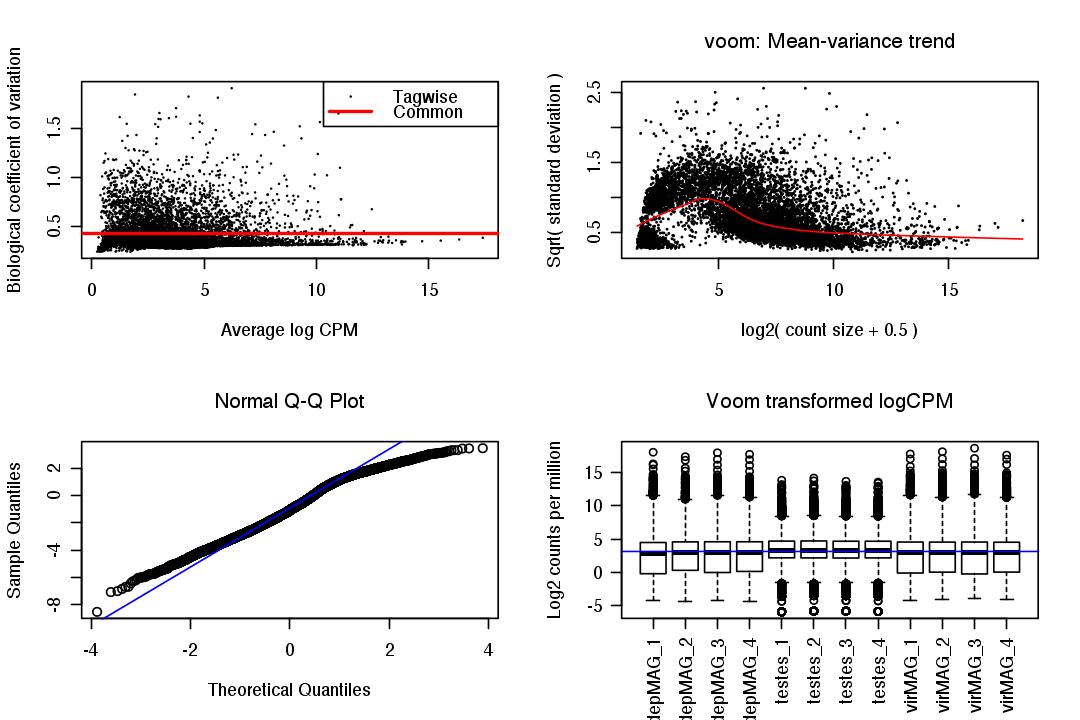

In [45]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(e.dgeList)
# mean-variance trend
voomC = voom(e.dgeList, e.design, plot=TRUE)
# QQ-plot
g <- gof(e.dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

We'll compare the virgin MAG sample with the depleted MAG sample:

In [103]:
vMAG.v.dMAG <- makeContrasts(vMAG.vs.dMAG=virMAG-depMAG,
                             levels=e.design)

lrt.dvMAG <- glmLRT(e.dgeList_fit, contrast = vMAG.v.dMAG)

lrt.dvMAG.tTags <- topTags(lrt.dvMAG, n = NULL)
lrt.dvMAG.tTags.table <- lrt.dvMAG.tTags$table
dvMAG.list<-subset(lrt.dvMAG.tTags.table, logFC < -2 & FDR<0.001 | logFC > 2 & FDR<0.001)$GeneID
length(dvMAG.list)
# MAG.list
head(subset(lrt.dvMAG.tTags.table, GeneID %in% dvMAG.list))

[1] 164

,GeneID,Description,logFC,logCPM,LR,PValue,FDR
3146,MSTRG.30862,uncharacterized LOC5567429,-11.812225,3.230314,181.4907,2.290606e-41,2.172181e-37
1210,MSTRG.17508,uncharacterized LOC5564993,-6.452093,3.742135,151.7191,7.298195e-35,3.460439e-31
2686,MSTRG.30722,sodium-dependent nutrient amino acid transporter 1,-10.228375,1.838018,141.6552,1.156871e-32,3.656870e-29
7814,MSTRG.7693,TP53-regulated inhibitor of apoptosis 1,-10.327022,2.006727,140.1637,2.451449e-32,5.811772e-29
4716,MSTRG.2546,NA,-8.788274,4.617140,125.8820,3.263161e-29,6.188911e-26
2592,MSTRG.14089,pyrroline-5-carboxylate reductase 1%2C mitochondrial,-6.745953,4.615297,114.3736,1.079319e-26,1.705864e-23


We'll create a cluster object and generate a heatmap:

In [104]:
MAG_DE.meanCPM = subset(meanCPMmatrix, rownames(meanCPMmatrix) %in% dvMAG.list)
MAG_DE.meanCPM = subset(MAG_DE.meanCPM, select=c("depMAG", "testes", "virMAG"))

In [105]:
data = MAG_DE.meanCPM
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')

myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

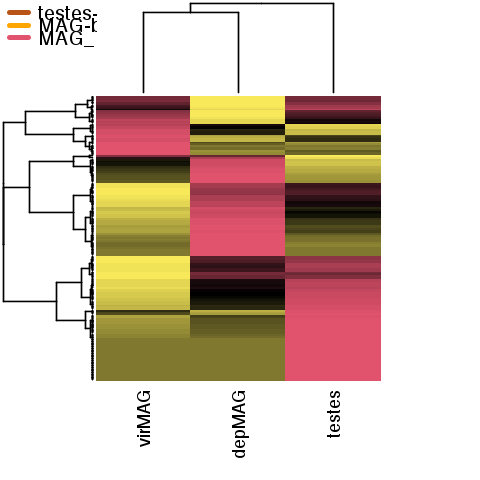

In [125]:
options(repr.plot.width = 4, repr.plot.height = 4)
heatmap3(heatmap_data, 
         col=myheatcol, 
         cexCol = 1, 
         labRow = "", 
         legendfun=function() showLegend(legend=c("testes-biased", "MAG-biased", "MAG_DE"), col=c("#b85516", "orange", "#e1526d")), 
        cex.main=0.75)

Looks like 8 clusters summarize the variation:

In [107]:
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=12)
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

We'll loop over the cluster assignments and import them into the cluster list object:

In [108]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_data = rbindlist(cluster_list)
head(cluster_data)

depMAG,testes,virMAG,Gene_ID,cluster
0.8009365,0.3980389,-1.198975,MSTRG.10165,cluster_1
1.1592016,0.4565722,-1.615774,MSTRG.1021,cluster_1
1.1128399,0.3244182,-1.437258,MSTRG.10576,cluster_1
1.0764970,0.1983050,-1.274802,MSTRG.20909,cluster_1
1.9281641,0.4472839,-2.375448,MSTRG.2544,cluster_1
1.3995830,0.3536009,-1.753184,MSTRG.32525,cluster_1


We'll reshape first:

In [109]:
cluster_data.m = melt(cluster_data, id.vars = c("Gene_ID", "cluster"))
head(cluster_data.m)

Gene_ID,cluster,variable,value
MSTRG.10165,cluster_1,depMAG,0.8009365
MSTRG.1021,cluster_1,depMAG,1.1592016
MSTRG.10576,cluster_1,depMAG,1.1128399
MSTRG.20909,cluster_1,depMAG,1.0764970
MSTRG.2544,cluster_1,depMAG,1.9281641
MSTRG.32525,cluster_1,depMAG,1.3995830


Now plot it:

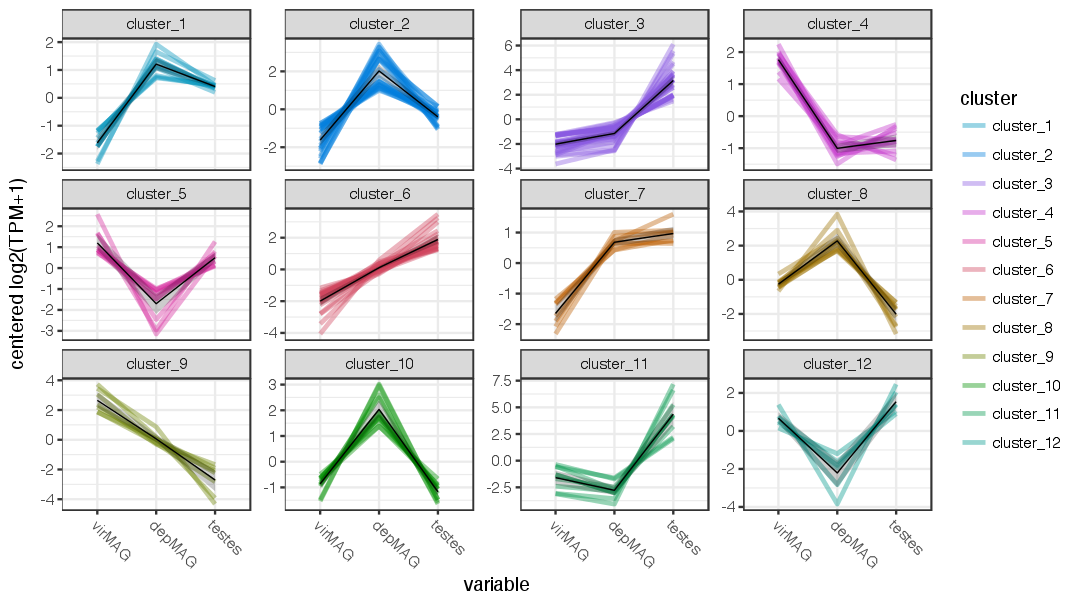

In [110]:
cluster_data.m$cluster = factor(cluster_data.m$cluster, levels = c("cluster_1", "cluster_2", "cluster_3", "cluster_4", "cluster_5", "cluster_6", "cluster_7", "cluster_8", "cluster_9", "cluster_10", "cluster_11", "cluster_12"))
cluster_data.m$variable = factor(cluster_data.m$variable, levels = c("virMAG", "depMAG", "testes"))
options(repr.plot.width = 9, repr.plot.height = 5)

ggplot(cluster_data.m, aes(variable, value, group= Gene_ID, colour = cluster)) + 
    geom_line(alpha = 0.4,
              size = 1) +
    theme_bw() + 
    facet_wrap('cluster',scales='free_y') +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = cluster_data.m, 
                 aes(x=variable,y=value, group = cluster),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(CPM+1)")

A volcano plot of the comparison between virgin and depleted MAGs:

In [132]:
dt = decideTestsDGE(lrt.dvMAG)
glXYPlot(x=lrt.dvMAG$table$logFC, y=-log10(lrt.dvMAG$table$PValue), xlab="logFC", ylab="logodds", status=dt, groups=subset(sampleData, Source == "Degner")$Sample, side.main="GeneID", counts = e.dgeList)

With Ethan's data we can make a TPM matrix using the mean transcript length (2922) as a proxy for gene length

In [138]:
# load TPM function
tpm <- function(counts, lengths) {
    rate <- counts / lengths
    rate / sum(rate) * 1e6
}

In [149]:
e.countsMatrix = subset(countsMatrix, select=c("depMAG_1", "depMAG_2", "depMAG_3", "depMAG_4", "testes_1", "testes_2", "testes_3", "testes_4", "virMAG_1", "virMAG_2", "virMAG_3", "virMAG_4"))
e.geneTPM <- apply(e.countsMatrix, 2, function(x) tpm(x, 2922))
e.geneTPM = as.data.frame(e.geneTPM)
head(e.geneTPM)

,depMAG_1,depMAG_2,depMAG_3,depMAG_4,testes_1,testes_2,testes_3,testes_4,virMAG_1,virMAG_2,virMAG_3,virMAG_4
MSTRG.19848,0.0000000,0.0000000,0.0000000,0.0000000,0.19711553,0.0000000,0.2160155,0.1336595,0.36619306,0.000000,0.000000,0.0000000
MSTRG.19849,1.0012531,0.7268493,0.3602899,0.2852630,1.37980871,1.0241716,0.6480465,0.5346378,0.00000000,1.101585,0.000000,0.4164896
MSTRG.19846,0.2145542,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000,0.000000,0.000000,0.0000000
MSTRG.19847,0.1430362,0.2907397,0.0000000,0.1426315,0.06570518,0.2731124,0.1440103,0.1336595,0.07323861,0.000000,0.224302,0.0000000
MSTRG.19844,0.7866989,0.7995342,0.0000000,0.3565787,2.16827083,0.2731124,0.4320310,0.8687865,0.00000000,0.000000,0.000000,0.0000000
MSTRG.19845,13.0162908,5.8874794,1.9455657,3.0665770,9.06731436,2.3214557,2.0881499,3.8761244,3.44221474,8.518927,1.570114,1.9158523
